In [1]:
import ecco
import torch
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import re

In [2]:
# !pip install ecco

In [3]:
# let's remember what we modified so we can restore the model

def modify_model_heads(model, layers, heads, memory, share):
    
    # offset of 1536 is the first value of the Values vector (as in Queries, Keys, Values)
    # The next 64 values constitute the first head in the Values vector - there are 12 heads total in "GPT-2 small" model
    head_offsets = [1536,1536+64,1536+128,1536+192,1536+256,1536+320, \
                    1536+384,1536+448,1536+512,1536+576,1536+640,1536+704]
    
    end_offset = int(64*(share/100))
    # modify
    # modify heads in all encoder layers
    for layer in layers:
        
        layer = int(layer)
        #print("Modifying layer: ",layer)
        # step through the 12 heads one at a time
        for head in heads:

            # get the offset value for the current head
            offset = head_offsets[head]

            # modify a random 50%
            #np.random.seed(1234)
            #rnd_index = np.random.randint(offset,offset+63,32) # 50% of the heads
            #if head < 3:
            #    print(rnd_index)

            # step through all 768 rows of the c_attn.weight matrix holding Query-Key-Values matrix (768x2304)
            for row in range(0,model.model.transformer.h[layer].attn.c_attn.weight.size()[0]):

                # The line below will do a random deletion
                #model.transformer.h[layer].attn.c_attn.weight[row][rnd_index] = \
                #    model.transformer.h[layer].attn.c_attn.weight[row][rnd_index].mul(0.0)
                

                # The line below will randomly shuffle the head corresponding to the "offset" (not really reproducible)
                #random.shuffle(model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31])

                with torch.no_grad():
                    # remember what we modify
                    memory[layer][row][offset:offset + end_offset] = model.model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + end_offset]
                
                    # The line below will turn all values of the current head to zero (reproducible)
                    # zero out only the first 16/32/48/64 values (25/50/75/100%) of each head
                    model.model.transformer.h[layer].attn.c_attn.weight[row][offset:offset+end_offset] = \
                        model.model.transformer.h[layer].attn.c_attn.weight[row][offset:offset+end_offset].mul(0.0)
                    model.model.transformer.h[layer].attn.c_attn.bias[offset:offset+end_offset] = \
                        model.model.transformer.h[layer].attn.c_attn.bias[offset:offset+end_offset].mul(0.0)
                
                # The line below will delete the last 50% of the values in each head
                #model.transformer.h[layer].attn.c_attn.weight[row][offset+47:offset + 63] = \
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset+47:offset + 63].mul(0.0)

                # The line below will delete the middle 50% of the values in each head
                #model.transformer.h[layer].attn.c_attn.weight[row][offset+15:offset + 47] = \
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset+15:offset + 47].mul(0.0)

                # let's implement a gradual damage across heads
                # assuming that 
                #if head < 8:
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31] = \
                #        model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31].mul(0.0)
                #if head >= 8:
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 15] = \
                #        model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 15].mul(0.0)
                
    return model, memory



In [4]:
def unmodify_model(model, layers, heads, memory, share):
     # offset of 1536 is the first value of the Values vector (as in Queries, Keys, Values)
    # The next 64 values constitute the first head in the Values vector - there are 12 heads total in "GPT-2 small" model
    head_offsets = [1536,1536+64,1536+128,1536+192,1536+256,1536+320, \
                    1536+384,1536+448,1536+512,1536+576,1536+640,1536+704]
    
    end_offset = int(64*(share/100))
    # modify
    # modify heads in all encoder layers
    for layer in layers:
        
        layer = int(layer)
        #print("Un-Modifying layer: ",layer)
        # step through the 12 heads one at a time
        for head in heads:

            # get the offset value for the current head
            offset = head_offsets[head]

            # step through all 768 rows of the c_attn.weight matrix holding Query-Key-Values matrix (768x2304)
            for row in range(memory.shape[1]):

                with torch.no_grad():
                    # The line below will turn all values of the current head to zero (reproducible)
                    # zero out only the first 16/32/48/64 values (25/50/75/100%) of each head
                    model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + end_offset] = \
                        memory[layer][row][offset:offset + end_offset]
                
                
    return model


In [5]:
import torch
torch.cuda.is_available()

False

In [6]:
%env CUDA_VISIBLE_DEVICES=1
# Load pre-trained language model. Setting 'activations' to True tells Ecco to capture neuron activations.
lm = ecco.from_pretrained('gpt2', activations=True)
dlm = ecco.from_pretrained('gpt2', activations=True)


env: CUDA_VISIBLE_DEVICES=1


# 3- identify layer names

We need the names of the embedding layer (to support attribution calculations) and the `FFNN layer` (to support neuron activation collection).

In [7]:
from transformers import AutoModel

In [8]:
lm_model = AutoModel.from_pretrained('gpt2')

In [9]:
lm_model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwis

In [10]:
dlm_model = AutoModel.from_pretrained('gpt2')

In [11]:
dlm_model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwis

In [12]:
layers = list(range(9))
heads = [0,1,2,3,4,5,6,7,8,9,10,11]
memory = torch.FloatTensor(np.zeros((12,768,2304))).to('cpu')

dlm, mem = modify_model_heads(dlm, layers, heads, memory, 50)

In [19]:
# Input text
# text = "There are two children and their mother in the kitchen. The little boy has climbed up, on a three legged stool to get some cookies from the jar in the cupboard."
text = "The little boy has climbed up, on a three legged stool to get some cookies from the jar in the cupboard."

# Pass in `attribution` argument the list of primary attributions to be computed
# With ['ig', 'grad_x_input'] we are calculating Integrated Gradients and Input X Gradient saliency attributions
# output = lm.generate(text, generate=20, do_sample=True, attribution=['ig', 'grad_x_input'])

In [20]:
# Generate 20 tokens to complete the input text.
output = lm.generate(text, generate=1, temperature=1, do_sample=True, top_p=0.9, attribution=['ig', 'grad_x_input'])

# Ecco will output each token as it is generated.

# 'output' now contains the data captured from this run, including the input and output tokens
# as well as neuron activations and input saliency values.

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [21]:
# An OutputSeq object is the result of running a language model on some input data. 
# It contains not only the output sequence of words generated by the model, but 
# also other data collecting during the generation process that is useful to analyze the model.

type(output)

ecco.output.OutputSeq

In [22]:
output.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

In [23]:
output.primary_attributions(attr_method='ig', style="detailed")

<IPython.core.display.Javascript object>

In [24]:
doutput = dlm.generate(text, generate=1, temperature=1, do_sample=True, top_p=0.9, attribution=['ig', 'grad_x_input'])



<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [25]:
doutput.primary_attributions(attr_method='grad_x_input')

<IPython.core.display.Javascript object>

In [26]:
doutput.primary_attributions(attr_method='grad_x_input', style="detailed")

<IPython.core.display.Javascript object>

In [29]:
# layer_predictions(): Which tokens did the model consider as the best outputs for a specific position in the sequence?

# To Visuallize in all layers
# doutput.layer_predictions(position=36)

# To visualize in last layer (11th layer)
doutput.layer_predictions(position=25, layer=11)

<IPython.core.display.Javascript object>

In [30]:
# 1
# Visualize # output_0.layer_predictions(position=6, layer=5)

# 2
# output = lm.generate(text, generate=1, do_sample=False)
# Visualize the candidate tokens at the last layer of the model (layer 5)
# output.layer_predictions(position=8, layer=5) 

# 3
# redictions for position 8
# We can see more tokens using the topk parameter
# output.layer_predictions(position=8, layer=5, topk=20)

# 4
# 
# Visualize the candidate tokens at every layer
# output.layer_predictions(position=6)

# # To Visuallize in all layers
# output.layer_predictions(position=36)

# # To Visuallize in last layer (11th layer)
output.layer_predictions(position=25, layer=11)

<IPython.core.display.Javascript object>

We also assessed differences in text generation between GPT-2 and GPT-D, by estimating repetitiveness and lexical frequency, as well as through salience-based visualization.

In [31]:
import numpy as np
from scipy.stats import ttest_ind
con = [6.62, 6.21, 7.4, 3.41, 8.74,
       1.69, 3.9, 1.34, 1.48, 1.19,
       3.24, 8.16, 7.23, 2.79, 1.47,
       1.95, 6.47, 1.44, 0.91, 4.65,
       1.35, 1.59, 4.08, 5.27, 7.42]
con_2 = [7.93, 3.66, 2.67, 5.46, 4.07,
         1.65, 2.79, 1.71, 2.3, 6.04,
         4.83, 2.82, 2.83, 5.09, 1.55,
         5.72, 0.85, 0.9, 0.48, 0.57,
         0.97, 1.97, 4.24, 4.18, 1.05,
         0.95, 1.03, 3.81, 0.72, 0.9, 2.68, 1.32, 0.84, 2.39, 2.94, 6.11]
dem = [5.24, 5.68, 2.86, 2.92, 3.73,
       1.32, 7.43, 2.26, 4.59, 1.88,
       1.93, 3.35, 4.06, 4.45, 1.81,
       2.06, 3.2, 2.09, 2.72, 5.1,
       2.81, 4.34, 4.77, 5.65, 13.74]
dem_2 = [2.75, 2.82, 1.6, 2.22, 3.64, 1.51, 2.46, 3.45, 5.03, 4.48, 7.63,
         2.68, 1.25, 2.07, 1.71, 2.63, 1.25, 3.79, 2.04, 2.7, 1.92, 1.73,
         2.51, 2.75, 3.19, 1.15, 1.76, 2.18, 2.17, 1.72, 2.76, 1.63, 2.33,
         3.22, 3.07, 8.21]
print("con mean saliency: {:0.2f}".format(np.mean(con)))
print("dem mean saliency: {:0.2f}".format(np.mean(dem)))
print("con total saliency: {:0.2f}".format(np.sum(con)))
print("dem total saliency: {:0.2f}".format(np.sum(dem)))
print("t-test p-value: {:0.3f}".format(ttest_ind(con, dem)[1]))
print("con mean saliency: {:0.2f}".format(np.mean(con_2)))
print("dem mean saliency: {:0.2f}".format(np.mean(dem_2)))
print("con total saliency: {:0.2f}".format(np.sum(con_2)))
print("dem total saliency: {:0.2f}".format(np.sum(dem_2)))
print("t-test p-value: {:0.3f}".format(ttest_ind(con_2, dem_2)[1]))

con mean saliency: 4.00
dem mean saliency: 4.00
con total saliency: 100.00
dem total saliency: 99.99
t-test p-value: 1.000
con mean saliency: 2.78
dem mean saliency: 2.78
con total saliency: 100.02
dem total saliency: 100.01
t-test p-value: 0.999


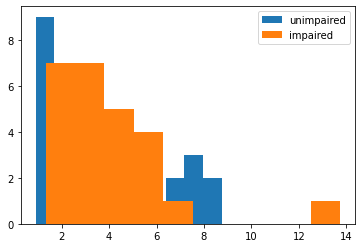

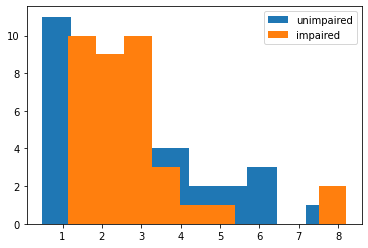

In [32]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()
ax1.hist(con, label="unimpaired")
ax1.hist(dem, label="impaired")
ax1.legend(loc="upper right")
plt.show()

fig2, ax2 = plt.subplots()
ax2.hist(con_2, label="unimpaired")
ax2.hist(dem_2, label="impaired")
ax2.legend(loc="upper right")
plt.show()